In [1]:
import os
import cv2 
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [2]:
trainpath="./Dataset/Train"

In [3]:
LABELS = ('Parasite','Uninfected')
IMG_SIZE=180
def get_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Total number of images we have 416


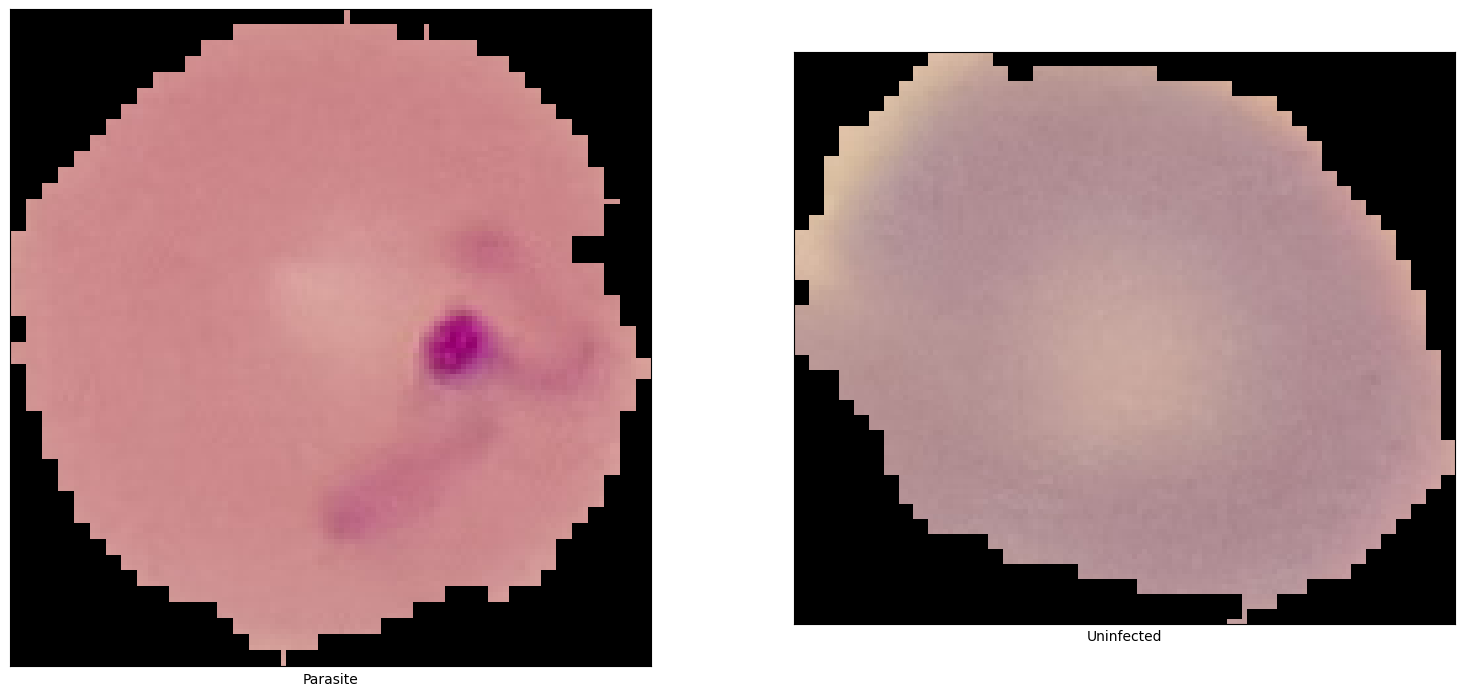

In [6]:
plt.figure(figsize=(70,70))
count=0
names=[]
total_images=0
for i in os.listdir(trainpath):
  count+=1
  names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(trainpath+"/"+i)
  total_images+=len(images_path)

  image_show=plt.imread(trainpath+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)

C:\Users\Aishvarya Selvakumar\AppData\Local\Temp\ipykernel_2100\1718855746.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(array([220.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 196.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

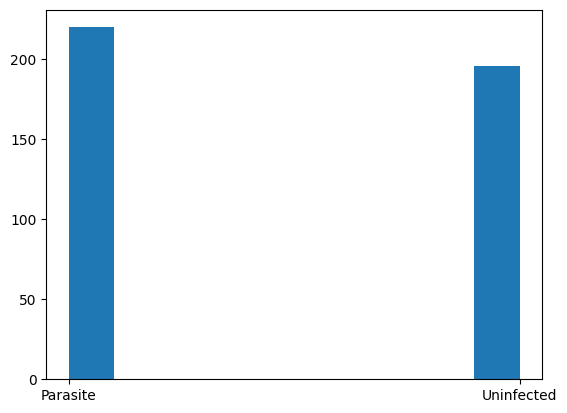

In [7]:
train_raw = get_data(trainpath)
count = []
for i in train_raw:
    if(i[1] == 1):
        count.append("Uninfected")
    else:
        count.append("Parasite")

plt.hist(count) #data splitting

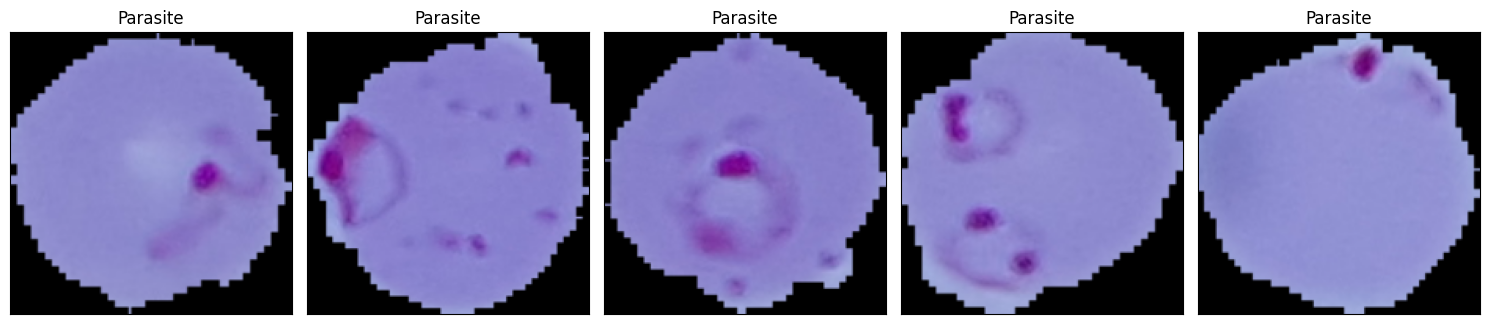

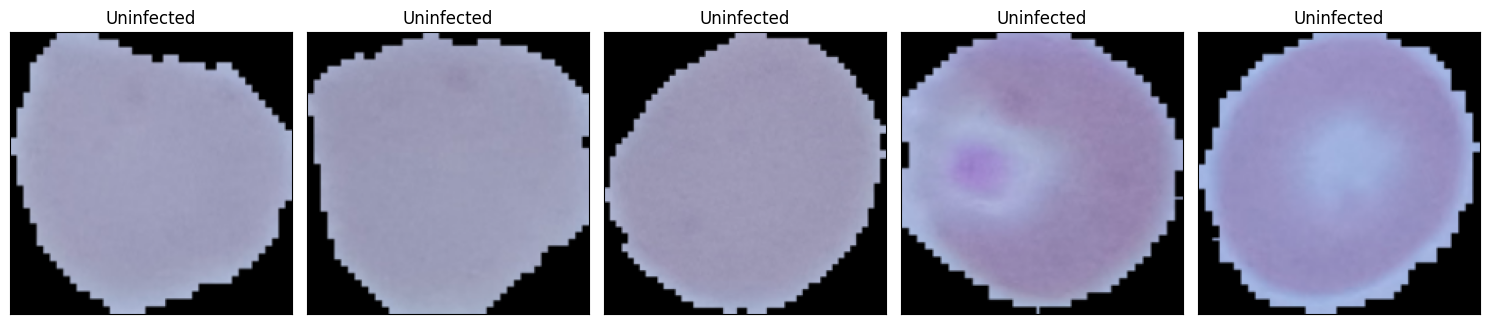

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
        img = train_raw[i][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Parasite")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
        img = train_raw[-(i+1)][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Uninfected")
fig.tight_layout()
plt.show()

In [9]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,validation_split = 0.25
 )

test_dataset = image.ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    './Dataset/Train/',
    target_size = (180,180),
    batch_size = 32,subset = 'training',
     class_mode = 'binary')

Found 312 images belonging to 2 classes.


In [11]:
validation_generator = train_datagen.flow_from_directory(
    './Dataset/Train/',
    target_size = (180,180),
    batch_size = 18,subset = 'validation',
    class_mode = 'binary',shuffle=True)

Found 104 images belonging to 2 classes.


In [12]:
dense_model = DenseNet121(input_shape=(180,180,3),include_top=False,weights="imagenet")
for layer in dense_model.layers:
    layer.trainable=False
model=Sequential()
model.add(dense_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 5, 5, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 batch_normalization (BatchN  (None, 25600)            102400    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              52430848  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [13]:
OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [14]:
hist = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
)

Epoch 1/10
10/10 [==============================] - 45s 3s/step - loss: 0.3211 - accuracy: 0.8526 - val_loss: 0.8864 - val_accuracy: 0.8942
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 0.1838 - accuracy: 0.9391 - val_loss: 0.4677 - val_accuracy: 0.9327
Epoch 3/10
10/10 [==============================] - 27s 3s/step - loss: 0.1686 - accuracy: 0.9455 - val_loss: 0.7319 - val_accuracy: 0.9231
Epoch 4/10
10/10 [==============================] - 27s 3s/step - loss: 0.1376 - accuracy: 0.9487 - val_loss: 0.2637 - val_accuracy: 0.9519
Epoch 5/10
10/10 [==============================] - 28s 3s/step - loss: 0.1173 - accuracy: 0.9583 - val_loss: 0.1509 - val_accuracy: 0.9615
Epoch 6/10
10/10 [==============================] - 28s 3s/step - loss: 0.1438 - accuracy: 0.9455 - val_loss: 0.2632 - val_accuracy: 0.9423
Epoch 7/10
10/10 [==============================] - 28s 3s/step - loss: 0.1055 - accuracy: 0.9519 - val_loss: 0.3510 - val_accuracy: 0.9231
Epoch 8/10
10/10 [==

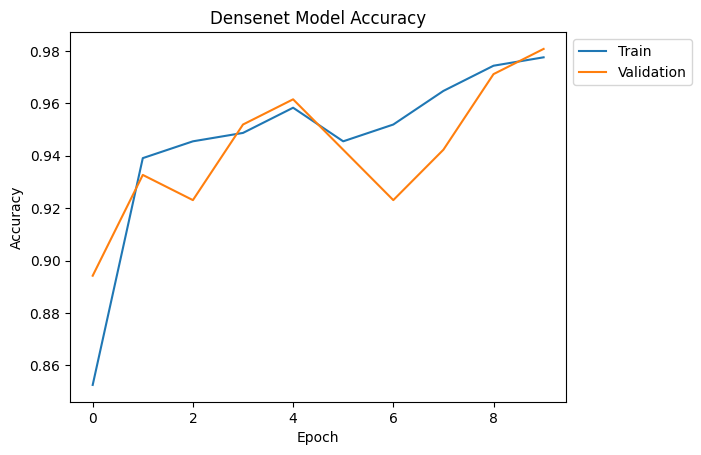

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

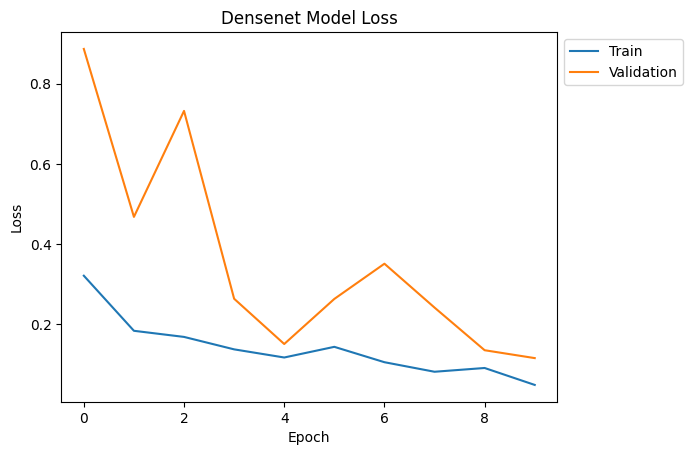

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
model.save("./weightdense.h5")

In [18]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(180,180, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model1.compile(optimizer='sgd', loss="binary_crossentropy", metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 96)        34944     
                                                                 
 batch_normalization_3 (Batc  (None, 43, 43, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       2973952   
                                                                 
 batch_normalization_4 (Batc  (None, 21, 21, 256)      1024      
 hNormalization)                                                 
                                                      

In [20]:
history = model1.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
)
model.save('weightalex.h5')

Epoch 1/10
10/10 [==============================] - 51s 5s/step - loss: 3.8839 - accuracy: 0.5353 - val_loss: 0.7114 - val_accuracy: 0.5288
Epoch 2/10
10/10 [==============================] - 48s 5s/step - loss: 0.7618 - accuracy: 0.6506 - val_loss: 0.6943 - val_accuracy: 0.5288
Epoch 3/10
10/10 [==============================] - 48s 5s/step - loss: 0.4936 - accuracy: 0.7532 - val_loss: 0.6982 - val_accuracy: 0.5385
Epoch 4/10
10/10 [==============================] - 48s 5s/step - loss: 0.5655 - accuracy: 0.7179 - val_loss: 0.6970 - val_accuracy: 0.5288
Epoch 5/10
10/10 [==============================] - 48s 5s/step - loss: 0.5471 - accuracy: 0.7340 - val_loss: 0.6819 - val_accuracy: 0.5865
Epoch 6/10
10/10 [==============================] - 48s 5s/step - loss: 0.4266 - accuracy: 0.7917 - val_loss: 0.6760 - val_accuracy: 0.5288
Epoch 7/10
10/10 [==============================] - 48s 5s/step - loss: 0.4485 - accuracy: 0.7885 - val_loss: 0.6635 - val_accuracy: 0.5962
Epoch 8/10
10/10 [==

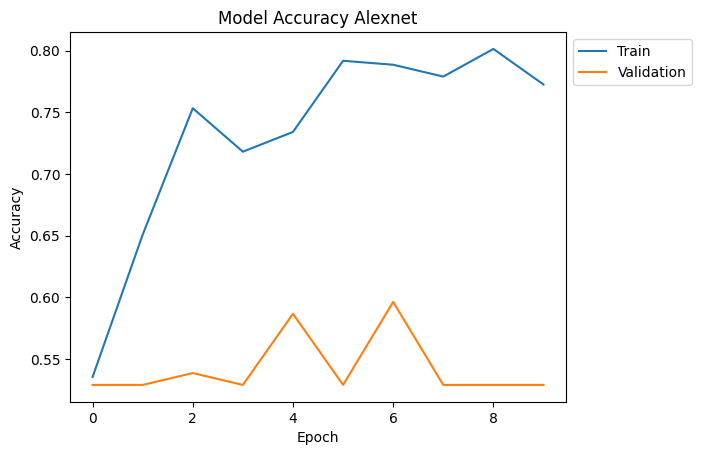

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Alexnet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

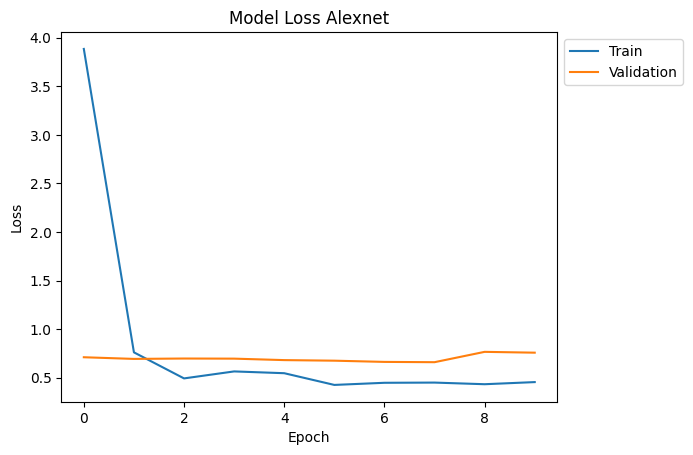

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Alexnet')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [ ]:
keras_model = tf.keras.models.load_model('weightdense.h5', compile=False) 
keras_model._name = 'model1'
keras_model2 = tf.keras.models.load_model('weightalex.h5', compile=False) 
keras_model2._name = 'model2'
models = [keras_model, keras_model2] 
model_input = tf.keras.Input(shape=(180,180,3))
model_outputs = [model(model_input) for model in models] 
ensemble_output = tf.keras.layers.max()(model_outputs) 
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [30]:
def predict(path):
    t=['Parasite','Uninfected']
    img=image.load_img(path, target_size=(180,180))
    img=image.img_to_array(img)
    img=img/255
    plt.imshow(img)
    plt.axis('off')
    img=np.expand_dims(img,axis=0)
    p=ensemble_model.predict(img)

    if(p<0.5):
        p=0
    else:
        p=1
    print("The image is of a "+t[p])
    

1/1 [==============================] - 0s 133ms/step
The image is of a Parasite


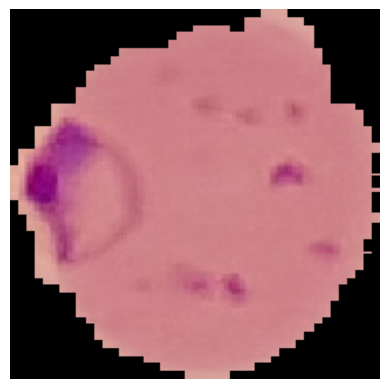

In [31]:
predict('./Dataset/Train/Parasite/C133P94ThinF_IMG_20151004_155721_cell_112.png')

1/1 [==============================] - 0s 114ms/step
The image is of a Parasite


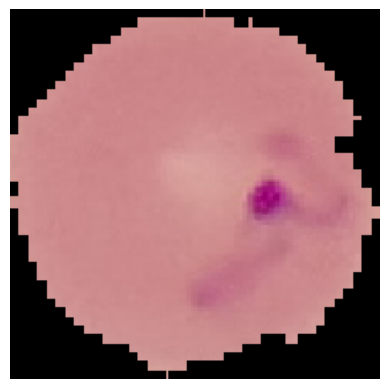

In [32]:
predict('./Dataset/Train/parasite/C133P94ThinF_IMG_20151004_155721_cell_111.png')

1/1 [==============================] - 0s 112ms/step
The image is of a Uninfected


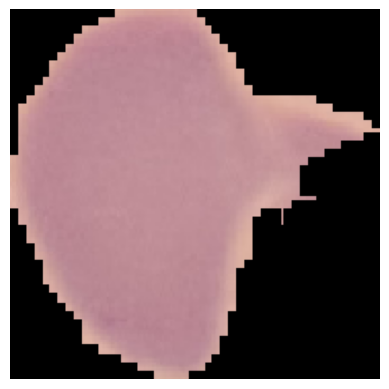

In [33]:
predict('./Dataset/Test/Uninfected/C3thin_original_IMG_20150608_162922_cell_145.png')